# TorchVision 0.3 Object Detection finetuning tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-etln6ded
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-etln6ded
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265564 sha256=fe78fcc3c5e7c100329912640de8d9a1af94d4f65148958ab13f3d41e0fae0bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-xrmgzk60/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Duckie Town

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [2]:
from PIL import Image
#Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/dataset"

0.npz	 14.npz   19.npz   249.npz  299.npz  348.npz  398.npz  447.npz	53.npz
100.npz  150.npz  1.npz    24.npz   29.npz   349.npz  399.npz  448.npz	54.npz
101.npz  151.npz  200.npz  250.npz  2.npz    34.npz   39.npz   449.npz	55.npz
102.npz  152.npz  201.npz  251.npz  300.npz  350.npz  3.npz    44.npz	56.npz
103.npz  153.npz  202.npz  252.npz  301.npz  351.npz  400.npz  450.npz	57.npz
104.npz  154.npz  203.npz  253.npz  302.npz  352.npz  401.npz  451.npz	58.npz
105.npz  155.npz  204.npz  254.npz  303.npz  353.npz  402.npz  452.npz	59.npz
106.npz  156.npz  205.npz  255.npz  304.npz  354.npz  403.npz  453.npz	5.npz
107.npz  157.npz  206.npz  256.npz  305.npz  355.npz  404.npz  454.npz	60.npz
108.npz  158.npz  207.npz  257.npz  306.npz  356.npz  405.npz  455.npz	61.npz
109.npz  159.npz  208.npz  258.npz  307.npz  357.npz  406.npz  456.npz	62.npz
10.npz	 15.npz   209.npz  259.npz  308.npz  358.npz  407.npz  457.npz	63.npz
110.npz  160.npz  20.npz   25.npz   309.npz  359.npz  408.npz  458.np

In [5]:
import numpy as np
dataset_1 = np.load('/content/drive/MyDrive/dataset/0.npz')

In [ ]:
dataset_1

In [ ]:
dataset_1.files

['arr_0', 'arr_1', 'arr_2']

In [ ]:
dataset_1['arr_1']

array([[153,  35, 223,  87]])

In [ ]:
npz_file_path = '/content/drive/MyDrive/dataset/0.npz'
npz_file_dict = np.load(npz_file_path)
num_records = len(npz_file_dict['arr_0'])

img = npz_file_dict[f"arr_{0}"]
boxes = npz_file_dict[f"arr_{1}"]
classes = npz_file_dict[f"arr_{2}"]


def get_items(num_records):
   for i in range(num_records):
      return img[i], boxes[i], classes[i]
# for i in glob.glob('*.npz'):
#     numpy_vars[np_name] = np.load(np_name)


In [ ]:
  img.shape

(224, 224, 3)

In [ ]:
num_records

224

In [6]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class DuckieDataset(torch.utils.data.Dataset):
    def __init__(self, root,  transforms=None):
        # initialization
        self.root = root
        #self.list_IDs = list_IDs
        self.transforms = transforms
        self.path = '/content/drive/MyDrive/dataset/'
        #self.imgs = list(sorted(os.listdir(path)))

    def __len__(self):
        return len(self.path)
        
 
    def __getitem__(self, idx):
        # load images ad masks
        #ID = self.list_IDs[idx]
        
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        
        # load data (not sure if we do np.load, or torch.load)
        npz_file_path = '/content/drive/MyDrive/dataset/'
        npz_file_dict = np.load(npz_file_path + str(idx) + '.npz')
        img = npz_file_dict[f"arr_{0}"]
        boxes = npz_file_dict[f"arr_{1}"]
        classes = npz_file_dict[f"arr_{2}"]
        #img = Image.open(img).convert('RGB')
        
        #img = img.transpose(2,0,1)
        img = img.reshape(3,224, 224)
        img = torch.as_tensor(img, dtype=torch.float32)
        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0]) 
        boxes = boxes[keep] 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        classes = classes
        labels = torch.as_tensor((classes), dtype=torch.int64)

        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


That's all for the dataset. Let's see how the outputs are structured for this dataset

In [7]:
dataset = DuckieDataset('/content/drive/MyDrive/dataset/')

dataset[0]

(tensor([[[255.,   0., 255.,  ..., 255., 255.,   0.],
          [255., 255.,   0.,  ...,   0., 255., 255.],
          [  0., 255., 255.,  ..., 255.,   0., 255.],
          ...,
          [  0., 255., 255.,  ..., 116., 114., 117.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0., 164., 219.]],
 
         [[  0., 219., 219.,  ..., 116., 114., 117.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],
 
         [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  .

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 5)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [9]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12256 (delta 3), reused 1 (delta 0), pack-reused 12249
Receiving objects: 100% (12256/12256), 13.47 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (8549/8549), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [10]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [11]:
# use our dataset and defined transformations
dataset = DuckieDataset(get_transform(train=True))
dataset_test = DuckieDataset(get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
dataset = torch.utils.data.Subset(dataset, range(0, 400))
dataset_test = torch.utils.data.Subset(dataset_test, range(300,400))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [13]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/200]  eta: 0:04:55  lr: 0.000000  loss: 218.3300 (218.3300)  loss_classifier: 167.8367 (167.8367)  loss_box_reg: 0.8498 (0.8498)  loss_objectness: 49.2202 (49.2202)  loss_rpn_box_reg: 0.4233 (0.4233)  time: 1.4762  data: 1.0827  max mem: 1619
Epoch: [0]  [ 10/200]  eta: 0:00:58  lr: 0.000001  loss: 66.2830 (92.1827)  loss_classifier: 60.8177 (76.7920)  loss_box_reg: 0.5372 (0.7152)  loss_objectness: 4.0338 (13.4769)  loss_rpn_box_reg: 0.8898 (1.1986)  time: 0.3091  data: 0.1468  max mem: 1885
Epoch: [0]  [ 20/200]  eta: 0:00:50  lr: 0.000001  loss: 11.9013 (51.7427)  loss_classifier: 1.9477 (40.6691)  loss_box_reg: 0.4525 (0.6207)  loss_objectness: 3.7971 (9.6080)  loss_rpn_box_reg: 0.6284 (0.8450)  time: 0.2196  data: 0.0813  max mem: 1885
Epoch: [0]  [ 30/200]  eta: 0:00:43  lr: 0.000002  loss: 4.0108 (37.5020)  loss_classifier: 0.9318 (27.8727)  loss_box_reg: 0.4091 (0.5446)  loss_objectness: 2.7985 (8.2972)  loss_rpn_box_reg: 0.4273 (0.7874)  time: 0.2266  data: 0.

#Model Checkpoint save

In [16]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
        

In [18]:
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now that training has finished, let's have a look at what it actually predicts in a test image

In [19]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [20]:
prediction

[{'boxes': tensor([[  0.0000,  88.0800,  27.6211, 106.8034],
          [  0.0000,   8.2850, 151.5132, 162.8147],
          [  0.0000,  75.7268, 224.0000, 156.6401],
          [ 17.9723,  60.7403, 185.7222, 138.0727],
          [  0.0000, 170.9290, 124.7929, 200.4859],
          [ 22.5377,  27.6003, 220.2709,  63.3934],
          [ 16.7467,  38.7473, 128.0023,  99.6804],
          [185.1766, 185.2156, 211.4926, 210.5097],
          [166.7910, 150.3871, 208.7434, 207.0043],
          [ 21.9000,  37.0759, 218.2239, 195.6512],
          [ 42.7215,  64.1217, 205.9946,  96.2052],
          [ 10.4787,  57.7156, 175.5271,  87.4769],
          [  0.0000, 157.1068, 146.3099, 186.9339],
          [  0.0000,  10.3850, 148.4418, 172.2945],
          [134.8318,  69.4643, 204.8895, 136.3717],
          [ 20.7710,  45.5430, 197.1770,  79.7840],
          [  0.0000,  41.0303, 224.0000,  96.2940],
          [  9.0015,  66.4285, 132.7011,  95.5708],
          [ 98.3184, 143.5949, 206.1450, 209.1509],
   

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

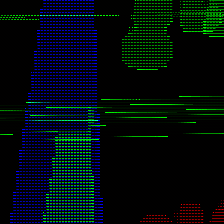

In [21]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [42]:
prediction

[{'boxes': tensor([[  0.0000,  88.0800,  27.6211, 106.8034],
          [  0.0000,   8.2850, 151.5132, 162.8147],
          [  0.0000,  75.7268, 224.0000, 156.6401],
          [ 17.9723,  60.7403, 185.7222, 138.0727],
          [  0.0000, 170.9290, 124.7929, 200.4859],
          [ 22.5377,  27.6003, 220.2709,  63.3934],
          [ 16.7467,  38.7473, 128.0023,  99.6804],
          [185.1766, 185.2156, 211.4926, 210.5097],
          [166.7910, 150.3871, 208.7434, 207.0043],
          [ 21.9000,  37.0759, 218.2239, 195.6512],
          [ 42.7215,  64.1217, 205.9946,  96.2052],
          [ 10.4787,  57.7156, 175.5271,  87.4769],
          [  0.0000, 157.1068, 146.3099, 186.9339],
          [  0.0000,  10.3850, 148.4418, 172.2945],
          [134.8318,  69.4643, 204.8895, 136.3717],
          [ 20.7710,  45.5430, 197.1770,  79.7840],
          [  0.0000,  41.0303, 224.0000,  96.2940],
          [  9.0015,  66.4285, 132.7011,  95.5708],
          [ 98.3184, 143.5949, 206.1450, 209.1509],
   

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
Image.fromarray(prediction[0]['boxes'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 

